In [2]:
import sys
sys.path.append('../code')
from synthetic_funcs import *
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [3]:
run_num = 10 
epoch_num = 2000
exp_ver = '6'

start_lambda1 = 0.5
start_temp  = 1.0

# Data preparation

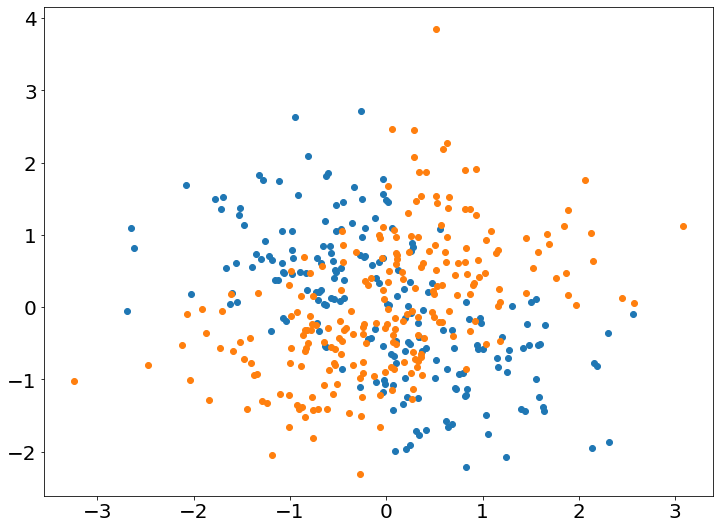

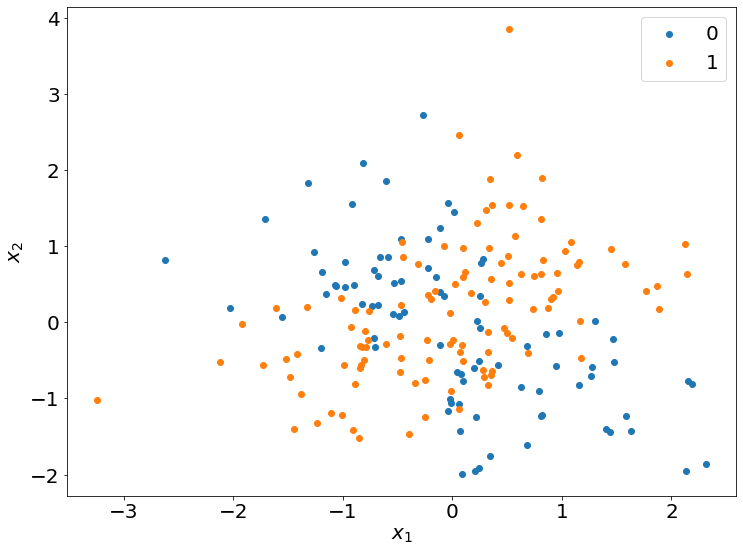

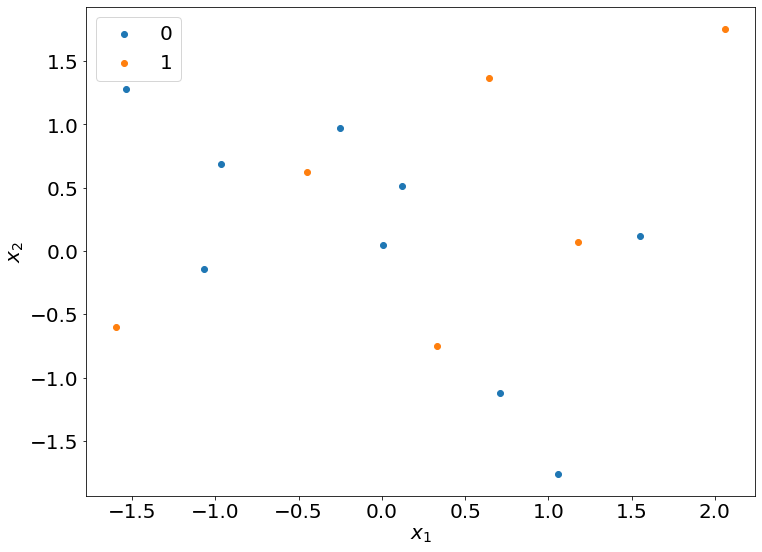

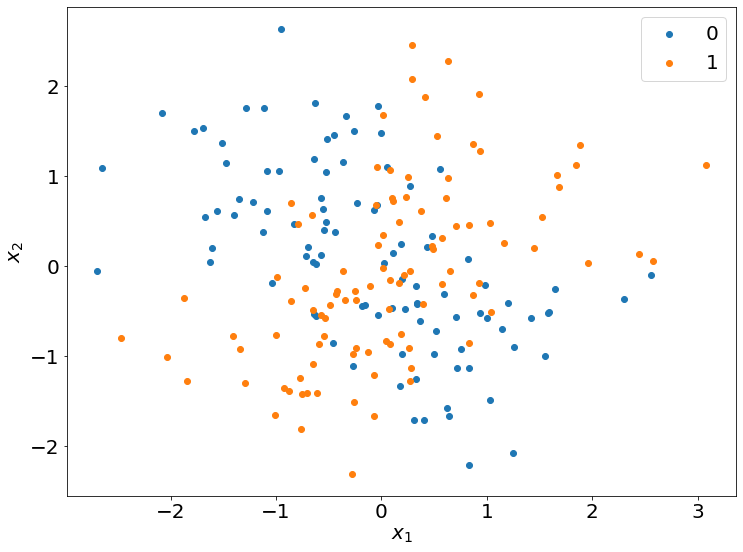

In [4]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='0')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/ttrain.pdf')
plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='0')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/train.pdf')
plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='0')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('../figs/test.pdf')
plt.legend()
plt.show()


# Experiments

### teacher training

In [5]:
# обучение учителя

teacher=net_training(20000, x_net_train=x_ttrain, y_net_train=y_ttrain, x_net_test=x_test,
             y_net_test=y_test, order=[0,1,2], lr0=1e-2)

0.575
0.615
0.66
0.665
0.665
0.67
0.665
0.675
0.675
0.685
0.685
0.69
0.69
0.69
0.685
0.69
0.69
0.69
0.69
0.69


### without distillation

In [10]:
# обучение студента без дистилляции

start_lambda1=1.0
start_temp=1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

0.745
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755
0.755


### full distillation

In [11]:
# полная дистилляция

start_lambda1 = 0.0
start_temp = 1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

0.615
0.56
0.56
0.56
0.56
0.56
0.56
0.56
0.56
0.56


### distillation with different coefficients

In [12]:
# дистилляция с разными коэффициентами

start_lambda1 = .5
start_temp = 1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

0.655
0.775
0.775
0.775
0.775
0.775
0.775
0.775
0.775
0.775


### distillation with random meta-parameters

In [6]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

filename='random'
synthetic_base(exp_ver, run_num, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], teacher=teacher,
               x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, mode='random', lr0=1.0)

../code/synthetic_funcs.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g = F.log_softmax(out/temp)


{'epoch': 0, 'accuracy': 0.6200000047683716, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 200, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 400, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 600, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 800, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1000, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1200, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1400, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1600, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1800, 'accuracy': 0.75, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 0, 'accuracy': 0.5049999952316284, 'temp': 1.5751320123672485, 

{'epoch': 0, 'accuracy': 0.3499999940395355, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 200, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 400, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 600, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 800, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1000, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1200, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1400, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1600, 'accuracy': 0.7200000286102295, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1800, 'accuracy': 0.72000

### with meta-parameter optimization

In [14]:
# дистилляция с оптимизацией гиперапарметров
import importlib
import synthetic_funcs
importlib.reload(synthetic_funcs)
synthetic_opt = synthetic_funcs.synthetic_opt
filename='opt'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher=teacher, 
              x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, 
              alg_pars=[(10, 2)], lr0=1.0, lr=.1, mode='opt')

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 7.969393253326416, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.3711199760437012}
{'epoch': 200, 'accuracy': 0.75, 'temp': 7.927047252655029, 'lambda1': 0.5695376396179199, 'te2': 0.1, 'test loss': 1.2141103744506836}
{'epoch': 400, 'accuracy': 0.75, 'temp': 7.869289875030518, 'lambda1': 0.7695350646972656, 'te2': 0.1, 'test loss': 1.0694493055343628}
{'epoch': 600, 'accuracy': 0.7699999809265137, 'temp': 7.811248779296875, 'lambda1': 0.9695324897766113, 'te2': 0.1, 'test loss': 0.6617391109466553}
{'epoch': 800, 'accuracy': 0.7950000166893005, 'temp': 7.808265209197998, 'lambda1': 0.9685991406440735, 'te2': 0.1, 'test loss': 0.517307460308075}
{'epoch': 1000, 'accuracy': 0.800000011920929, 'temp': 7.807779788970947, 'lambda1': 0.9690500497817993, 'te2': 0.1, 'test loss': 0.4982655644416809}
{'epoch': 1200, 'accuracy': 0.800000011920929, 'temp': 7.807663917541504, 'lambda1': 0.9692543148994446, 'te2': 0.1, 'test loss': 

{'epoch': 1000, 'accuracy': 0.7749999761581421, 'temp': 8.553568840026855, 'lambda1': 0.9981532096862793, 'te2': 0.1, 'test loss': 0.6284918189048767}
{'epoch': 1200, 'accuracy': 0.7950000166893005, 'temp': 8.552566528320312, 'lambda1': 0.9738118052482605, 'te2': 0.1, 'test loss': 0.5245121121406555}
{'epoch': 1400, 'accuracy': 0.7950000166893005, 'temp': 8.552030563354492, 'lambda1': 0.9738996624946594, 'te2': 0.1, 'test loss': 0.5014526844024658}
{'epoch': 1600, 'accuracy': 0.800000011920929, 'temp': 8.551887512207031, 'lambda1': 0.9741565585136414, 'te2': 0.1, 'test loss': 0.4955570697784424}
{'epoch': 1800, 'accuracy': 0.800000011920929, 'temp': 8.551887512207031, 'lambda1': 0.9742307662963867, 'te2': 0.1, 'test loss': 0.4939268231391907}
{'epoch': 0, 'accuracy': 0.5899999737739563, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 4.349343776702881}
{'epoch': 200, 'accuracy': 0.5699999928474426, 'temp': 0.3988737165927887, 'lambda1': 0.70496648550

### distillation with linear models (par: epoch_size)

In [17]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (100, 2), (500, 2), (1000, 2)], 
              lr0 = 1.0, lr = 0.1, mode='splines')

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 7.969393253326416, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.3711199760437012}
{'epoch': 200, 'accuracy': 0.75, 'temp': 7.92856502532959, 'lambda1': 0.5657437443733215, 'te2': 0.1, 'test loss': 1.216065526008606}
{'epoch': 400, 'accuracy': 0.75, 'temp': 7.871387004852295, 'lambda1': 0.7657411694526672, 'te2': 0.1, 'test loss': 1.0734238624572754}
{'epoch': 600, 'accuracy': 0.7699999809265137, 'temp': 7.8120222091674805, 'lambda1': 0.9657385945320129, 'te2': 0.1, 'test loss': 0.6743510961532593}
{'epoch': 800, 'accuracy': 0.800000011920929, 'temp': 7.811061382293701, 'lambda1': 0.9546663761138916, 'te2': 0.1, 'test loss': 0.5220556259155273}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 7.807125091552734, 'lambda1': 0.9977667331695557, 'te2': 0.1, 'test loss': 0.51253342628479}
{'epoch': 1200, 'accuracy': 0.7900000214576721, 'temp': 7.810678958892822, 'lambda1': 0.95976722240448, 'te2': 0.1, 'test loss': 0.5

{'epoch': 1000, 'accuracy': 0.7799999713897705, 'temp': 8.555342674255371, 'lambda1': 0.982498824596405, 'te2': 0.1, 'test loss': 0.674715518951416}
{'epoch': 1200, 'accuracy': 0.7950000166893005, 'temp': 8.55368709564209, 'lambda1': 0.9420007467269897, 'te2': 0.1, 'test loss': 0.537645697593689}
{'epoch': 1400, 'accuracy': 0.7799999713897705, 'temp': 8.54903507232666, 'lambda1': 0.9800002574920654, 'te2': 0.1, 'test loss': 0.5385551452636719}
{'epoch': 1600, 'accuracy': 0.7950000166893005, 'temp': 8.545907020568848, 'lambda1': 0.9863541126251221, 'te2': 0.1, 'test loss': 0.5108498930931091}
{'epoch': 1800, 'accuracy': 0.7950000166893005, 'temp': 8.546533584594727, 'lambda1': 0.9494231939315796, 'te2': 0.1, 'test loss': 0.508071780204773}
{'epoch': 0, 'accuracy': 0.5899999737739563, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 4.349343776702881}
{'epoch': 200, 'accuracy': 0.625, 'temp': 0.3733467757701874, 'lambda1': 0.6364926695823669, 'te2': 0.1

{'epoch': 0, 'accuracy': 0.7549999952316284, 'temp': 0.539410412311554, 'lambda1': 0.2931446433067322, 'te2': 0.1, 'test loss': 0.5208632946014404}
{'epoch': 200, 'accuracy': 0.800000011920929, 'temp': 0.7252187728881836, 'lambda1': 0.24618008732795715, 'te2': 0.1, 'test loss': 0.5545740723609924}
{'epoch': 400, 'accuracy': 0.7749999761581421, 'temp': 0.6957730054855347, 'lambda1': 0.37711483240127563, 'te2': 0.1, 'test loss': 0.5101065635681152}
{'epoch': 600, 'accuracy': 0.7900000214576721, 'temp': 0.8626055121421814, 'lambda1': 0.2632371187210083, 'te2': 0.1, 'test loss': 0.5792199969291687}
{'epoch': 800, 'accuracy': 0.7749999761581421, 'temp': 0.7181192636489868, 'lambda1': 0.4383732080459595, 'te2': 0.1, 'test loss': 0.536775529384613}
{'epoch': 1000, 'accuracy': 0.7749999761581421, 'temp': 0.9151947498321533, 'lambda1': 0.24235445261001587, 'te2': 0.1, 'test loss': 0.6269530057907104}
{'epoch': 1200, 'accuracy': 0.7799999713897705, 'temp': 0.7173995971679688, 'lambda1': 0.440352

{'epoch': 1000, 'accuracy': 0.5, 'temp': 7.694478511810303, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 6.944128513336182}
{'epoch': 1200, 'accuracy': 0.7450000047683716, 'temp': 7.669315814971924, 'lambda1': 0.8318958282470703, 'te2': 0.1, 'test loss': 0.9194507002830505}
{'epoch': 1400, 'accuracy': 0.6850000023841858, 'temp': 7.600784778594971, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.1216635704040527}
{'epoch': 1600, 'accuracy': 0.75, 'temp': 7.630205154418945, 'lambda1': 0.8808923959732056, 'te2': 0.1, 'test loss': 0.8057239055633545}
{'epoch': 1800, 'accuracy': 0.46000000834465027, 'temp': 7.570600509643555, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 14.236257553100586}
{'epoch': 0, 'accuracy': 0.4300000071525574, 'temp': 4.137040138244629, 'lambda1': 0.9646320343017578, 'te2': 0.1, 'test loss': 6.800241470336914}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 3.9776389598846436, 'lambda1': 0.861795961856842, 'te2': 0.1, 'test loss': 0.5187966823577881}
{'epoch': 400, 'accura

{'epoch': 0, 'accuracy': 0.6399999856948853, 'temp': 2.112705945968628, 'lambda1': 0.2597799599170685, 'te2': 0.1, 'test loss': 1.1029127836227417}
{'epoch': 200, 'accuracy': 0.7599999904632568, 'temp': 1.9127099514007568, 'lambda1': 0.4597773849964142, 'te2': 0.1, 'test loss': 0.6945422887802124}
{'epoch': 400, 'accuracy': 0.8149999976158142, 'temp': 1.739151954650879, 'lambda1': 0.6391314268112183, 'te2': 0.1, 'test loss': 0.4945439398288727}
{'epoch': 600, 'accuracy': 0.7149999737739563, 'temp': 1.5848987102508545, 'lambda1': 0.7947355508804321, 'te2': 0.1, 'test loss': 0.7141514420509338}
{'epoch': 800, 'accuracy': 0.5600000023841858, 'temp': 1.4169377088546753, 'lambda1': 0.9658125638961792, 'te2': 0.1, 'test loss': 1.8754246234893799}
{'epoch': 1000, 'accuracy': 0.5149999856948853, 'temp': 1.2488164901733398, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 3.023331642150879}
{'epoch': 1200, 'accuracy': 0.6700000166893005, 'temp': 1.2901322841644287, 'lambda1': 0.8000025749206543, 'te2':

{'epoch': 1200, 'accuracy': 0.3499999940395355, 'temp': 6.4200639724731445, 'lambda1': 0.8000025749206543, 'te2': 0.1, 'test loss': 371.57672119140625}
{'epoch': 1400, 'accuracy': 0.7450000047683716, 'temp': 6.242524147033691, 'lambda1': 0.7215288281440735, 'te2': 0.1, 'test loss': 1.0085424184799194}
{'epoch': 1600, 'accuracy': 0.75, 'temp': 6.062529563903809, 'lambda1': 0.6212599277496338, 'te2': 0.1, 'test loss': 1.080897331237793}
{'epoch': 1800, 'accuracy': 0.75, 'temp': 5.881110191345215, 'lambda1': 0.5182009935379028, 'te2': 0.1, 'test loss': 1.1462681293487549}
{'epoch': 0, 'accuracy': 0.6700000166893005, 'temp': 0.24558447301387787, 'lambda1': 0.08949250727891922, 'te2': 0.1, 'test loss': 2.62117075920105}
{'epoch': 200, 'accuracy': 0.8050000071525574, 'temp': 0.4126434028148651, 'lambda1': 0.19655434787273407, 'te2': 0.1, 'test loss': 0.5300313830375671}
{'epoch': 400, 'accuracy': 0.8149999976158142, 'temp': 0.609725832939148, 'lambda1': 0.2670348882675171, 'te2': 0.1, 'test 

{'epoch': 200, 'accuracy': 0.7450000047683716, 'temp': 3.854534149169922, 'lambda1': 0.33557865023612976, 'te2': 0.1, 'test loss': 1.1499367952346802}
{'epoch': 400, 'accuracy': 0.7549999952316284, 'temp': 3.6545486450195312, 'lambda1': 0.5355761051177979, 'te2': 0.1, 'test loss': 0.9570412635803223}
{'epoch': 600, 'accuracy': 0.7599999904632568, 'temp': 3.4545631408691406, 'lambda1': 0.7355735301971436, 'te2': 0.1, 'test loss': 0.6821509003639221}
{'epoch': 800, 'accuracy': 0.800000011920929, 'temp': 3.3463690280914307, 'lambda1': 0.8567526340484619, 'te2': 0.1, 'test loss': 0.4939456582069397}
{'epoch': 1000, 'accuracy': 0.7950000166893005, 'temp': 3.202908754348755, 'lambda1': 1.0021535158157349, 'te2': 0.1, 'test loss': 0.4992932975292206}
{'epoch': 1200, 'accuracy': 0.4449999928474426, 'temp': 3.0459065437316895, 'lambda1': 1.1643081903457642, 'te2': 0.1, 'test loss': 24.811725616455078}
{'epoch': 1400, 'accuracy': 0.3700000047683716, 'temp': 2.888904333114624, 'lambda1': 1.326462

{'epoch': 1400, 'accuracy': 0.75, 'temp': 0.6750103235244751, 'lambda1': -0.13770997524261475, 'te2': 0.1, 'test loss': 3.122765302658081}
{'epoch': 1600, 'accuracy': 0.7450000047683716, 'temp': 0.7466965913772583, 'lambda1': -0.25614917278289795, 'te2': 0.1, 'test loss': 7.499328136444092}
{'epoch': 1800, 'accuracy': 0.7450000047683716, 'temp': 0.8183829188346863, 'lambda1': -0.37458834052085876, 'te2': 0.1, 'test loss': 17.331693649291992}
{'epoch': 0, 'accuracy': 0.5550000071525574, 'temp': 0.1715053915977478, 'lambda1': 0.3574657440185547, 'te2': 0.1, 'test loss': 2.7177810668945312}
{'epoch': 200, 'accuracy': 0.8050000071525574, 'temp': 0.34150436520576477, 'lambda1': 0.17346696555614471, 'te2': 0.1, 'test loss': 0.5325243473052979}
{'epoch': 400, 'accuracy': 0.8149999976158142, 'temp': 0.5415018200874329, 'lambda1': 0.24197962880134583, 'te2': 0.1, 'test loss': 0.5193383693695068}
{'epoch': 600, 'accuracy': 0.8149999976158142, 'temp': 0.7050350904464722, 'lambda1': 0.302996039390

### distillation with linear models (par: train_splines_every_epoch) 

In [19]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (10, 3), (10, 5), (10, 10)], 
              lr0 = 1.0, lr = 0.1, mode='splines')

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 7.969393253326416, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.3711199760437012}
{'epoch': 200, 'accuracy': 0.75, 'temp': 7.92856502532959, 'lambda1': 0.5657437443733215, 'te2': 0.1, 'test loss': 1.216065526008606}
{'epoch': 400, 'accuracy': 0.75, 'temp': 7.871387004852295, 'lambda1': 0.7657411694526672, 'te2': 0.1, 'test loss': 1.0734238624572754}
{'epoch': 600, 'accuracy': 0.7699999809265137, 'temp': 7.8120222091674805, 'lambda1': 0.9657385945320129, 'te2': 0.1, 'test loss': 0.6743510961532593}
{'epoch': 800, 'accuracy': 0.800000011920929, 'temp': 7.811061382293701, 'lambda1': 0.9546663761138916, 'te2': 0.1, 'test loss': 0.5220556259155273}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 7.807125091552734, 'lambda1': 0.9977667331695557, 'te2': 0.1, 'test loss': 0.51253342628479}
{'epoch': 1200, 'accuracy': 0.7900000214576721, 'temp': 7.810678958892822, 'lambda1': 0.95976722240448, 'te2': 0.1, 'test loss': 0.5

{'epoch': 1000, 'accuracy': 0.7799999713897705, 'temp': 8.555342674255371, 'lambda1': 0.982498824596405, 'te2': 0.1, 'test loss': 0.674715518951416}
{'epoch': 1200, 'accuracy': 0.7950000166893005, 'temp': 8.55368709564209, 'lambda1': 0.9420007467269897, 'te2': 0.1, 'test loss': 0.537645697593689}
{'epoch': 1400, 'accuracy': 0.7799999713897705, 'temp': 8.54903507232666, 'lambda1': 0.9800002574920654, 'te2': 0.1, 'test loss': 0.5385551452636719}
{'epoch': 1600, 'accuracy': 0.7950000166893005, 'temp': 8.545907020568848, 'lambda1': 0.9863541126251221, 'te2': 0.1, 'test loss': 0.5108498930931091}
{'epoch': 1800, 'accuracy': 0.7950000166893005, 'temp': 8.546533584594727, 'lambda1': 0.9494231939315796, 'te2': 0.1, 'test loss': 0.508071780204773}
{'epoch': 0, 'accuracy': 0.5899999737739563, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 4.349343776702881}
{'epoch': 200, 'accuracy': 0.625, 'temp': 0.3733467757701874, 'lambda1': 0.6364926695823669, 'te2': 0.1

{'epoch': 0, 'accuracy': 0.7549999952316284, 'temp': 0.539410412311554, 'lambda1': 0.2931446433067322, 'te2': 0.1, 'test loss': 0.5208632946014404}
{'epoch': 200, 'accuracy': 0.8149999976158142, 'temp': 0.5775632858276367, 'lambda1': 0.2643645107746124, 'te2': 0.1, 'test loss': 0.5163666009902954}
{'epoch': 400, 'accuracy': 0.8149999976158142, 'temp': 0.5817681550979614, 'lambda1': 0.2623654007911682, 'te2': 0.1, 'test loss': 0.5114635229110718}
{'epoch': 600, 'accuracy': 0.8199999928474426, 'temp': 0.6007831692695618, 'lambda1': 0.24436645209789276, 'te2': 0.1, 'test loss': 0.5237889885902405}
{'epoch': 800, 'accuracy': 0.8149999976158142, 'temp': 0.5816025137901306, 'lambda1': 0.2643671929836273, 'te2': 0.1, 'test loss': 0.5167366862297058}
{'epoch': 1000, 'accuracy': 0.8149999976158142, 'temp': 0.5840914249420166, 'lambda1': 0.2623680830001831, 'te2': 0.1, 'test loss': 0.5116698145866394}
{'epoch': 1200, 'accuracy': 0.8199999928474426, 'temp': 0.6023863554000854, 'lambda1': 0.244369

{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 7.706979274749756, 'lambda1': 0.9460431933403015, 'te2': 0.1, 'test loss': 0.5678699016571045}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 7.702394008636475, 'lambda1': 0.9640429615974426, 'te2': 0.1, 'test loss': 0.5208011865615845}
{'epoch': 1400, 'accuracy': 0.800000011920929, 'temp': 7.695137023925781, 'lambda1': 0.9860426783561707, 'te2': 0.1, 'test loss': 0.5064818263053894}
{'epoch': 1600, 'accuracy': 0.7799999713897705, 'temp': 7.692964553833008, 'lambda1': 0.9460431933403015, 'te2': 0.1, 'test loss': 0.5347221493721008}
{'epoch': 1800, 'accuracy': 0.7799999713897705, 'temp': 7.685830116271973, 'lambda1': 0.9640429615974426, 'te2': 0.1, 'test loss': 0.5116823315620422}
{'epoch': 0, 'accuracy': 0.4300000071525574, 'temp': 4.137040138244629, 'lambda1': 0.9646320343017578, 'te2': 0.1, 'test loss': 6.800241470336914}
{'epoch': 200, 'accuracy': 0.800000011920929, 'temp': 4.058263301849365, 'lambda1': 0.8952916264533

{'epoch': 0, 'accuracy': 0.6399999856948853, 'temp': 2.112705945968628, 'lambda1': 0.2597799599170685, 'te2': 0.1, 'test loss': 1.1029127836227417}
{'epoch': 200, 'accuracy': 0.7599999904632568, 'temp': 1.9127143621444702, 'lambda1': 0.4597773849964142, 'te2': 0.1, 'test loss': 0.6945436000823975}
{'epoch': 400, 'accuracy': 0.7900000214576721, 'temp': 1.7147051095962524, 'lambda1': 0.657774806022644, 'te2': 0.1, 'test loss': 0.4945993423461914}
{'epoch': 600, 'accuracy': 0.7900000214576721, 'temp': 1.7147051095962524, 'lambda1': 0.657774806022644, 'te2': 0.1, 'test loss': 0.4945569336414337}
{'epoch': 800, 'accuracy': 0.7900000214576721, 'temp': 1.7147051095962524, 'lambda1': 0.657774806022644, 'te2': 0.1, 'test loss': 0.4945569634437561}
{'epoch': 1000, 'accuracy': 0.7900000214576721, 'temp': 1.7147051095962524, 'lambda1': 0.657774806022644, 'te2': 0.1, 'test loss': 0.4945569634437561}
{'epoch': 1200, 'accuracy': 0.7900000214576721, 'temp': 1.7147051095962524, 'lambda1': 0.65777480602

{'epoch': 1000, 'accuracy': 0.7799999713897705, 'temp': 6.8158979415893555, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 0.5842492580413818}
{'epoch': 1200, 'accuracy': 0.7749999761581421, 'temp': 6.8062639236450195, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 0.5836338996887207}
{'epoch': 1400, 'accuracy': 0.7749999761581421, 'temp': 6.796860694885254, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 0.5829142928123474}
{'epoch': 1600, 'accuracy': 0.7749999761581421, 'temp': 6.787661075592041, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 0.582200288772583}
{'epoch': 1800, 'accuracy': 0.7749999761581421, 'temp': 6.778660774230957, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 0.5815017223358154}
{'epoch': 0, 'accuracy': 0.6700000166893005, 'temp': 0.24558447301387787, 'lambda1': 0.08949250727891922, 'te2': 0.1, 'test loss': 2.62117075920105}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 0.24558447301387787, 'lambda1': 0.08949249982

{'epoch': 0, 'accuracy': 0.574999988079071, 'temp': 4.020554542541504, 'lambda1': 0.13992422819137573, 'te2': 0.1, 'test loss': 2.505706787109375}
{'epoch': 200, 'accuracy': 0.7450000047683716, 'temp': 3.8755393028259277, 'lambda1': 0.3035011887550354, 'te2': 0.1, 'test loss': 1.1755119562149048}
{'epoch': 400, 'accuracy': 0.75, 'temp': 3.675553798675537, 'lambda1': 0.5034986138343811, 'te2': 0.1, 'test loss': 0.9906101226806641}
{'epoch': 600, 'accuracy': 0.7649999856948853, 'temp': 3.4755682945251465, 'lambda1': 0.7034960389137268, 'te2': 0.1, 'test loss': 0.7319092750549316}
{'epoch': 800, 'accuracy': 0.7850000262260437, 'temp': 3.2775826454162598, 'lambda1': 0.901493489742279, 'te2': 0.1, 'test loss': 0.5374534130096436}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 3.2775826454162598, 'lambda1': 0.901493489742279, 'te2': 0.1, 'test loss': 0.5367968678474426}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 3.2775826454162598, 'lambda1': 0.901493489742279, 'te2': 0

{'epoch': 1200, 'accuracy': 0.7749999761581421, 'temp': 0.2841445505619049, 'lambda1': 0.24798612296581268, 'te2': 0.1, 'test loss': 0.5145084261894226}
{'epoch': 1400, 'accuracy': 0.7749999761581421, 'temp': 0.2841445505619049, 'lambda1': 0.24798612296581268, 'te2': 0.1, 'test loss': 0.5145084261894226}
{'epoch': 1600, 'accuracy': 0.7749999761581421, 'temp': 0.2841445505619049, 'lambda1': 0.24798612296581268, 'te2': 0.1, 'test loss': 0.5145084261894226}
{'epoch': 1800, 'accuracy': 0.7749999761581421, 'temp': 0.2841445505619049, 'lambda1': 0.24798612296581268, 'te2': 0.1, 'test loss': 0.5145084261894226}
{'epoch': 0, 'accuracy': 0.5550000071525574, 'temp': 0.1715053915977478, 'lambda1': 0.3574657440185547, 'te2': 0.1, 'test loss': 2.7177810668945312}
{'epoch': 200, 'accuracy': 0.8199999928474426, 'temp': 0.36950433254241943, 'lambda1': 0.15946808457374573, 'te2': 0.1, 'test loss': 0.5515024065971375}
{'epoch': 400, 'accuracy': 0.8149999976158142, 'temp': 0.38911980390548706, 'lambda1':

# Results

In [7]:
#data_b = open_data_json("../log/synthetic_exp6_nodistil.jsonl")
#data_d = open_data_json("../log/synthetic_exp6_distil.jsonl")
data_dr = open_data_json("../log/synthetic_exp6_random.jsonl")
data_h = open_data_json("../log/synthetic_exp6_opt.jsonl")
data_s = open_data_json("../log/synthetic_exp6_splines_esize_10_period_2.jsonl")


In [8]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [29]:
data_dr

[{'results': [{'epoch': 0,
    'accuracy': 0.6200000047683716,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355}],
  'version': '6'},
 {'results': [{'epoch': 0,
    'accuracy': 0.6200000047683716,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 200,
    'accuracy': 0.75,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355}],
  'version': '6'},
 {'results': [{'epoch': 0,
    'accuracy': 0.6200000047683716,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 200,
    'accuracy': 0.75,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 400,
    'accuracy': 0.75,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355}],
  'version': '6'},
 {'results': [{'epoch': 0,
    'accuracy': 0.6200000047683716,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 200,
    'accuracy': 0.75,
    'temp': 7.969455242156982,
    'lambda1': 0.37454012036

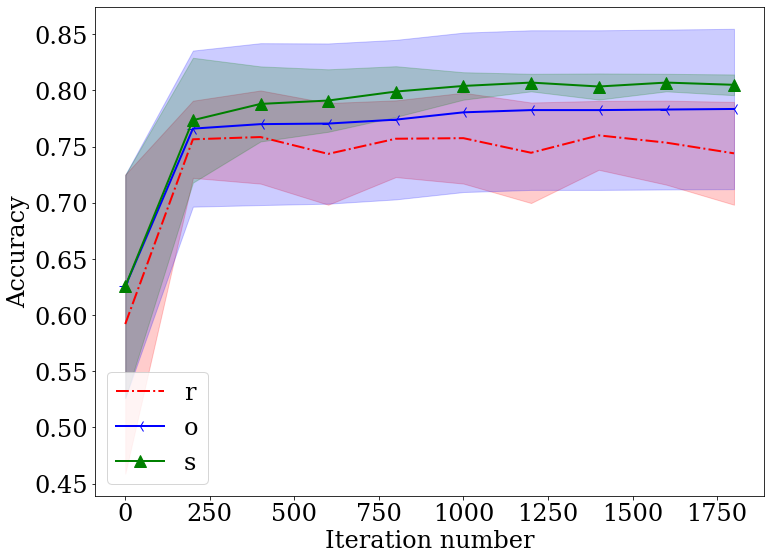

In [9]:
plot_data_params(data_dr, 'accuracy', 'r', 'red', '.')
plot_data_params(data_h, 'accuracy', 'o', 'blue', '3')
plot_data_params(data_s, 'accuracy', 's', 'green', '^')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.show()

In [11]:
data_10 = open_data_json("../log/synthetic_exp6_splines_esize_10_period_2.jsonl")
data_100 = open_data_json("../log/synthetic_exp6_splines_esize_100_period_2.jsonl")
data_500 = open_data_json("../log/synthetic_exp6_splines_esize_500_period_2.jsonl")
data_1000 = open_data_json("../log/synthetic_exp6_splines_esize_1000_period_2.jsonl")


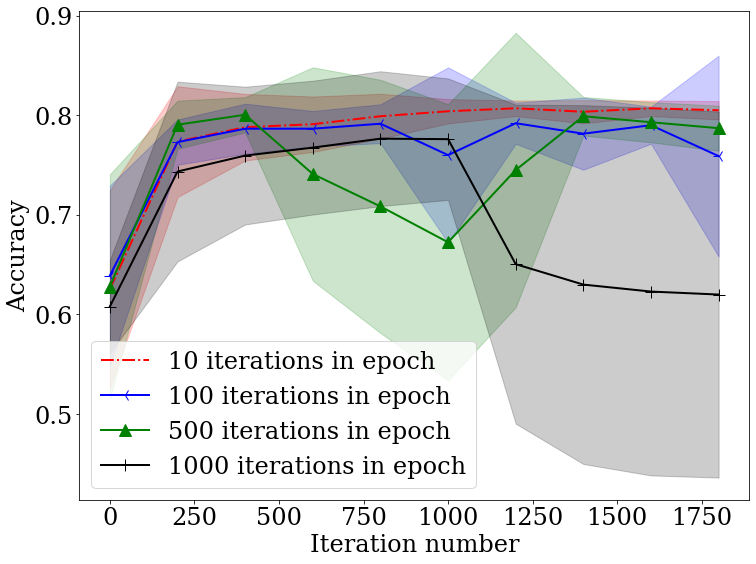

In [12]:
plot_data_params(data_10, 'accuracy', '10 iterations in epoch', 'red', '.')
plot_data_params(data_100, 'accuracy', '100 iterations in epoch', 'blue', '3')
plot_data_params(data_500, 'accuracy', '500 iterations in epoch', 'green', '^')
plot_data_params(data_1000, 'accuracy', '1000 iterations in epoch', 'black', '+')

plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
#plt.savefig('../figs/synthetic_exp3_linear_epoch_size.pdf')
plt.show()

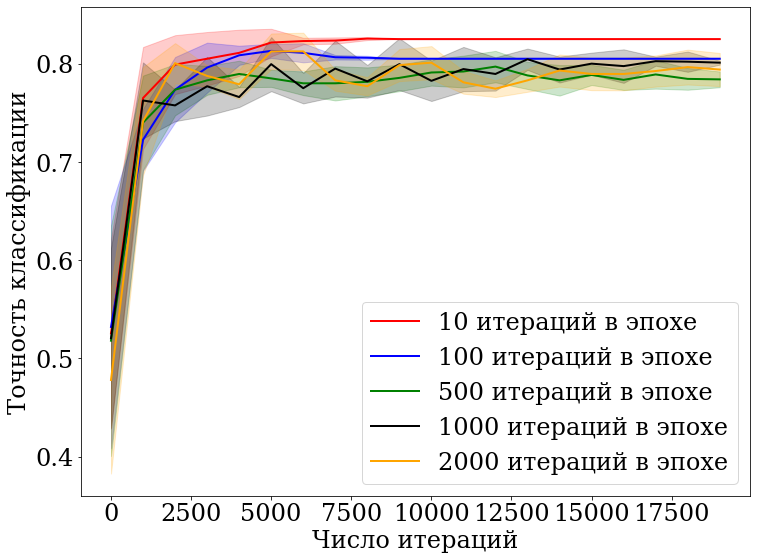

In [16]:
plot_data_params(data_10, 'accuracy', '10 iterations in epoch', 'red', '')
plot_data_params(data_100, 'accuracy', '100 iterations in epoch', 'blue', '')
plot_data_params(data_500, 'accuracy', '500 iterations in epoch', 'green', '')
plot_data_params(data_1000, 'accuracy', '1000 iterations in epoch', 'black', '')
plot_data_params(data_2000, 'accuracy', '2000 iterations in epoch', 'orange', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synthetic_exp3_linear_epoch_size_color.pdf')
plt.show()

In [13]:
data_2 = open_data_json("../log/synthetic_exp6_splines_esize_10_period_2.jsonl")
data_3 = open_data_json("../log/synthetic_exp6_splines_esize_10_period_3.jsonl")
data_5 = open_data_json("../log/synthetic_exp6_splines_esize_10_period_5.jsonl")
data_10 = open_data_json("../log/synthetic_exp6_splines_esize_10_period_10.jsonl")

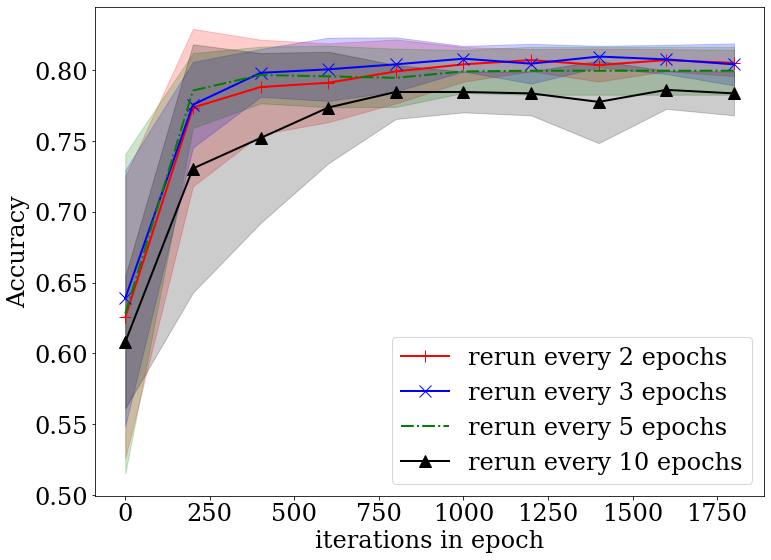

In [14]:
plot_data_params(data_2, 'accuracy', 'rerun every 2 epochs', 'red', '+')
plot_data_params(data_3, 'accuracy', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_5, 'accuracy', 'rerun every 5 epochs', 'green', '.')
plot_data_params(data_10, 'accuracy', 'rerun every 10 epochs', 'black', '^')
plt.legend()
plt.xlabel('iterations in epoch')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synthetic_exp3_linear_train_splines_every_epoch.pdf')
plt.show()

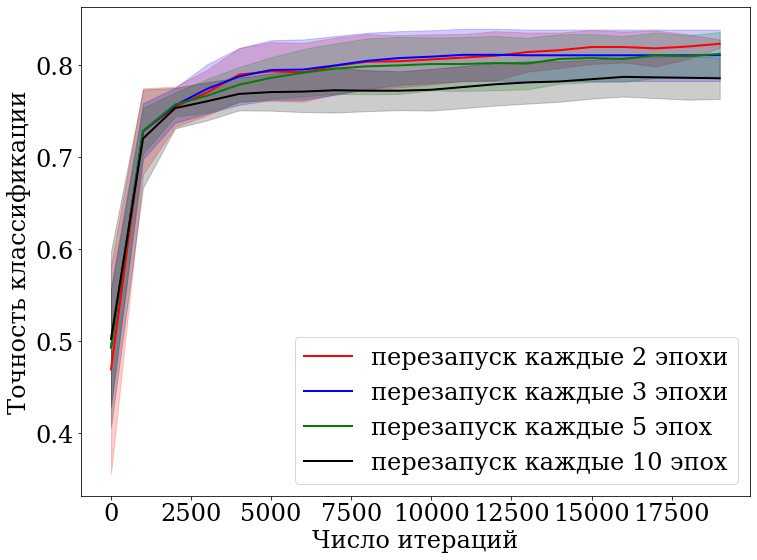

In [18]:
plot_data_params(data_2, 'accuracy', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_3, 'accuracy', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_5, 'accuracy', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_10, 'accuracy', 'rerun every 10 epochs', 'black', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synthetic_exp3_linear_train_splines_every_epoch_color.pdf')
plt.show()

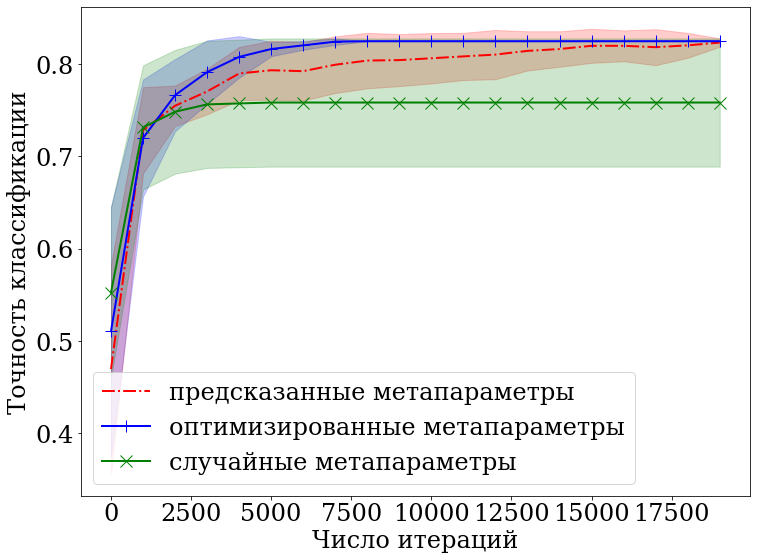

In [21]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '.')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '+')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', 'x')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter.pdf')
plt.show()

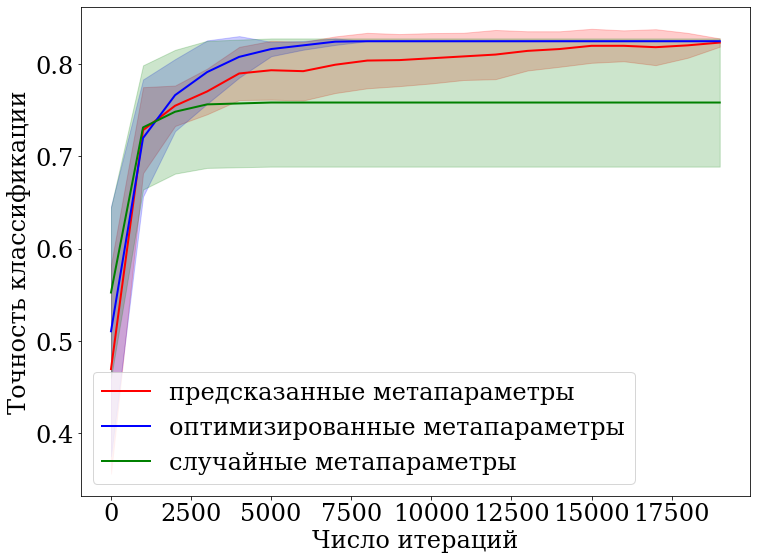

In [20]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter_color.pdf')
plt.show()

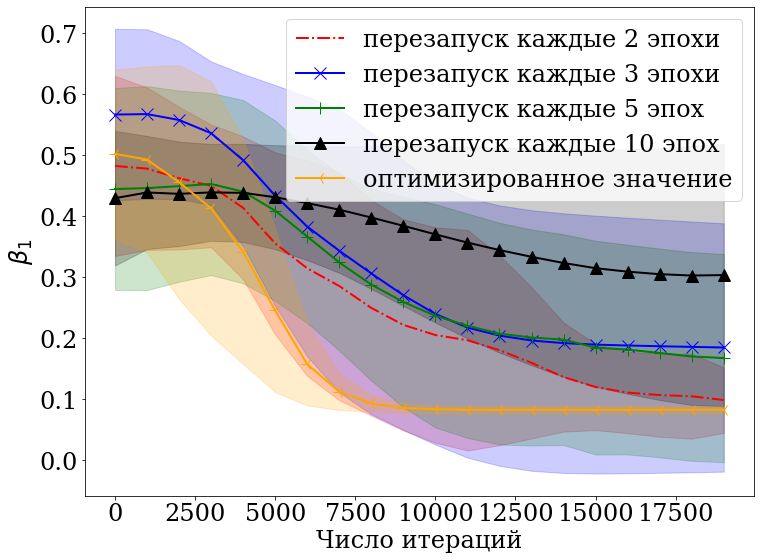

In [28]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter.pdf')
plt.show()

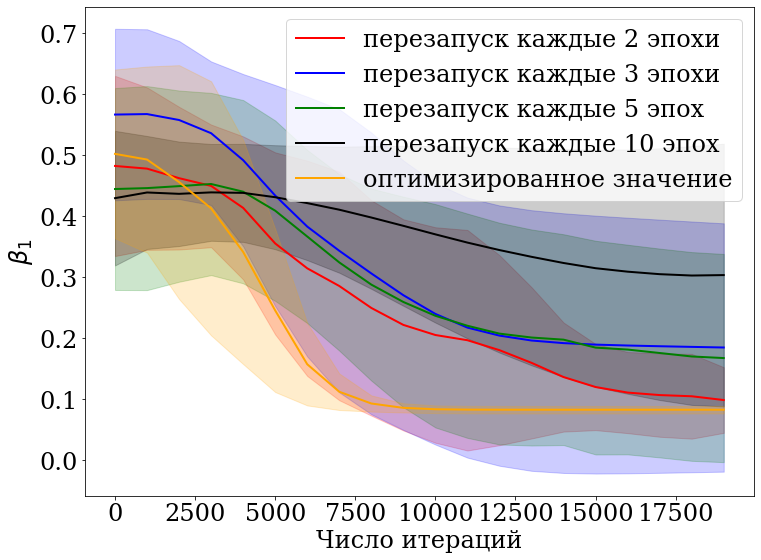

In [29]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter_color.pdf')
plt.show()

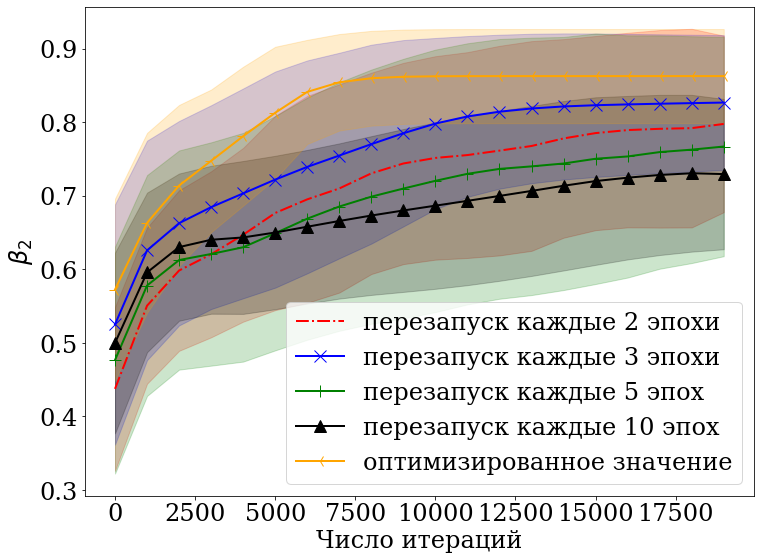

In [30]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda2','rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter.pdf')
plt.show()

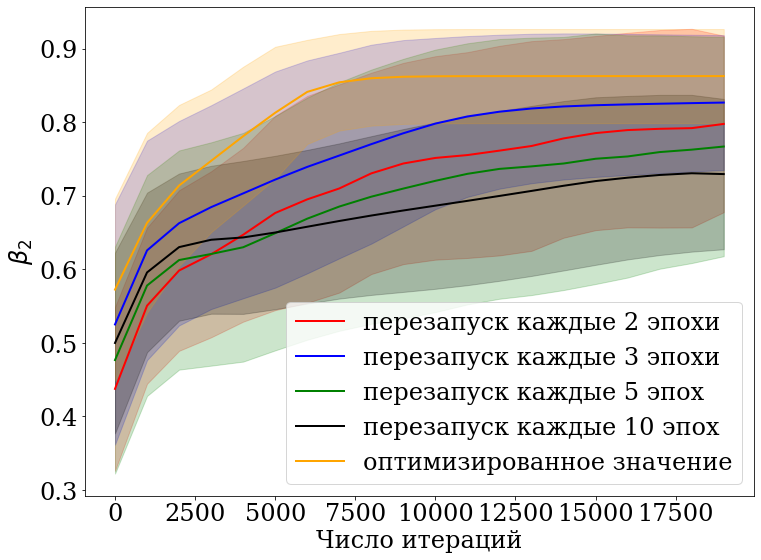

In [31]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda2', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter_color.pdf')
plt.show()

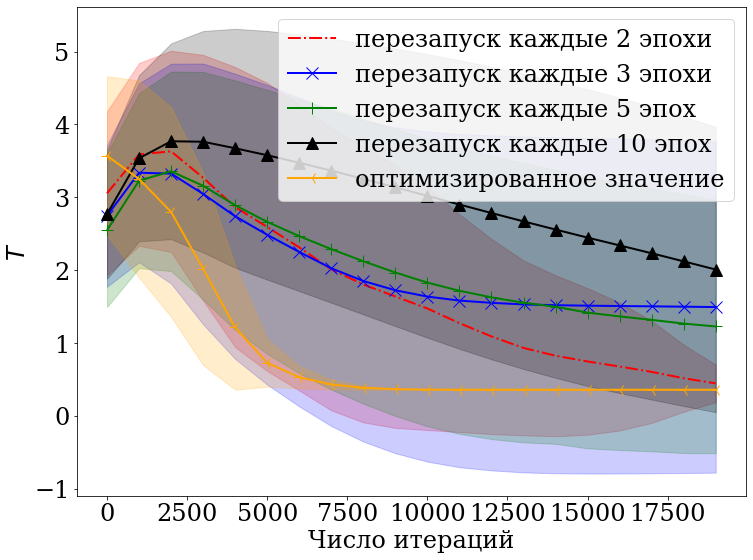

In [32]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter.pdf')
plt.show()

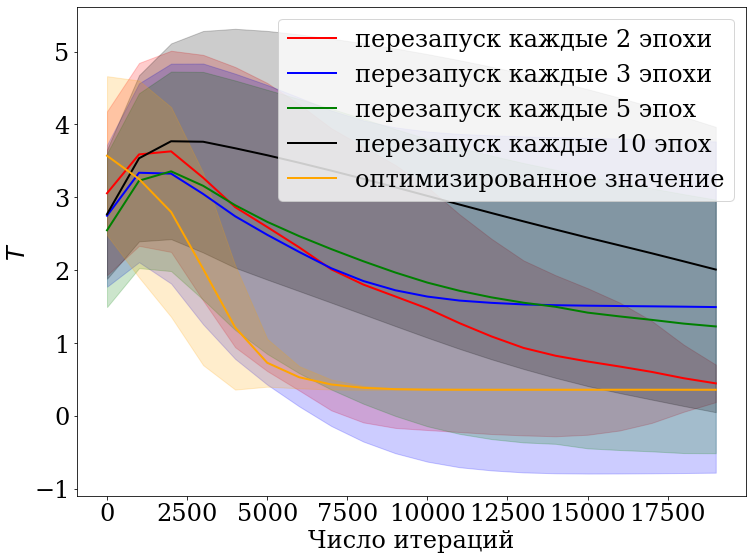

In [33]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter_color.pdf')
plt.show()